**Project**: Multimodal Learning Alignment of Brain Activity Representations \\
Giuseppe Misuraca (1944376) and Lorenzo Ciapetta (2011296)

## **Pipeline Idea (TO CHANGE)**

1) Dataset load and Data Processing
  - import dataset
  - perform standard eeg processing

2) Obtain image embedding from clip
  - for each image, related to the eeg sig, obtain the emebedding (using clip pretrained)
  - create a new dataset made of eeg signal and embedding
    
3) EEG Encoder Design
  - train the encoder
  - goal: match the eeg signal embedding with the image emebedding
  - needed: loss that align: Contrastive loss
  - evealutation of alignement (of eeg embed and img embed) with cosine measure

4) Diffusion Model
  - use pretrained and affine with clip embedding
  - send to it as input the eeg encoder output (so the clip alike emebedding)
  - evaluation of img gen
    - quantitative: CLIP similarity: if the image is the same as the one seen from subject: prendi img ouput diffusion model-> mettila dentro clip -> evedi quanto è allineata con la label
    - qualitative (human)


Honors Extension : align eeg not ust to the img but also to the text -> should be a similar pipeline



### Installations (FOR LOCAL RUNTIME ONLY!)

In [ ]:
#!pip install matplotlib
#!pip install numpy
#!pip install torch
#!pip install pytorch_lightning

# LIB

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.functional as F

import pytorch_lightning as pylight #lightning
from pytorch_lightning.callbacks import ModelCheckpoint

# Datasets

In [ ]:
%%capture
!pip install -U datasets

In [ ]:
import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## AllJoined 5-95 (EEG-EMBEDDING **BUT NO IMAGE**)

-> **Dataset che servirà per fare training di eeg encoder per allinearsi con clip image embedding ouput**

In [ ]:
dataset_clip = "/mnt/c/Users/loryx/Documenti/sincronizzato_con_drive/data/EEG/EEG-EmbedClip[AllJoined]" # "/content/drive/MyDrive/EEG-EmbedClip[AllJoined]"

In [ ]:
from datasets import load_from_disk

dataset_path = dataset_clip
dataset_emb = load_from_disk(dataset_path)

# first sample
first_sample = dataset_emb['train'][0]

print("EEG shape:", torch.tensor(first_sample['EEG']).shape)
print("EEG:", torch.tensor(first_sample['EEG']))
print("CLIP embedding shape:", torch.tensor(first_sample['clip_image_embedding']).shape)
print("CLIP embedding:", torch.tensor(first_sample['clip_image_embedding']))
print("Subject ID:", first_sample['subject_id'])
print("Session:", first_sample['session'])
print("Block:", first_sample['block'])
print("Trial:", first_sample['trial'])
print("73k ID:", first_sample['73k_id'])
print("COCO ID:", first_sample['coco_id'])
print("Current time:", first_sample['curr_time'])

EEG shape: torch.Size([63, 334])
EEG: tensor([[-1.5737e-07, -3.9757e-07,  3.2132e-07,  ..., -1.5839e-06,
         -9.4804e-07, -8.6426e-07],
        [ 5.9007e-07,  1.5436e-07,  9.8109e-07,  ..., -4.8373e-08,
         -1.2862e-06, -2.5605e-06],
        [ 4.2292e-07,  1.2000e-06,  1.5549e-06,  ...,  1.0367e-07,
         -6.6731e-07, -1.2147e-06],
        ...,
        [ 6.9381e-06,  4.7884e-06, -3.5725e-06,  ..., -6.2130e-08,
          1.1360e-09,  8.1945e-07],
        [ 1.9021e-06,  4.9759e-07, -2.6055e-06,  ...,  1.5919e-06,
          1.2992e-06,  1.3225e-06],
        [-1.5479e-07,  8.2434e-08, -8.7258e-07,  ...,  1.2533e-06,
          1.5848e-06,  1.8406e-06]])
CLIP embedding shape: torch.Size([1024])
CLIP embedding: tensor([-0.0104,  0.0215, -0.0201,  ..., -0.0171, -0.0004,  0.0465])
Subject ID: 1
Session: 1
Block: 1
Trial: 1
73k ID: 8647
COCO ID: 540928
Current time: 2.240234375


In [ ]:
train_data = dataset_emb['train']
print(f"Number of samples: {len(train_data)}\n")

print("Dataset features:")
for feature_name, feature_type in train_data.features.items():
    print(f"- {feature_name}: {feature_type}")

Number of samples: 42059

Dataset features:
- EEG: Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None)
- clip_image_embedding: Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)
- subject_id: Value(dtype='int32', id=None)
- session: Value(dtype='int32', id=None)
- block: Value(dtype='int32', id=None)
- trial: Value(dtype='int32', id=None)
- 73k_id: Value(dtype='int32', id=None)
- coco_id: Value(dtype='int32', id=None)
- curr_time: Value(dtype='float32', id=None)


## AllJoined 5-95 (EEG-IMAGE **BUT NO EMBEDDING**)

-> **Dataset che servirà per fare validazione che ouput diffusion model sia simile a immagine originaria mostrata a soggetti**

In [ ]:
from datasets import load_from_disk
from google.colab import drive
import os

dataset_dir = '/content/drive/MyDrive/EEG-Image[AllJoined]'
dataset_img = load_from_disk(dataset_dir)

Loading dataset from disk:   0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
train_data = dataset_img['train']
print(f"Number of samples: {len(train_data)}\n")

print("Dataset features:")
for feature_name, feature_type in train_data.features.items():
    print(f"- {feature_name}: {feature_type}")

Number of samples: 42059

Dataset features:
- EEG: Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None)
- image: Image(mode=None, decode=True, id=None)
- subject_id: Value(dtype='int32', id=None)
- session: Value(dtype='int32', id=None)
- block: Value(dtype='int32', id=None)
- trial: Value(dtype='int32', id=None)
- 73k_id: Value(dtype='int32', id=None)
- coco_id: Value(dtype='int32', id=None)
- curr_time: Value(dtype='float32', id=None)


In [ ]:
# Get the unique values in the 'coco_id' column
unique_coco_ids = set(train_data['coco_id'])

# Print the number of unique values
print(f"Number of unique coco_id values: {len(unique_coco_ids)}")

Number of unique coco_id values: 960


First sample

First sample keys: dict_keys(['EEG', 'image', 'subject_id', 'session', 'block', 'trial', '73k_id', 'coco_id', 'curr_time'])


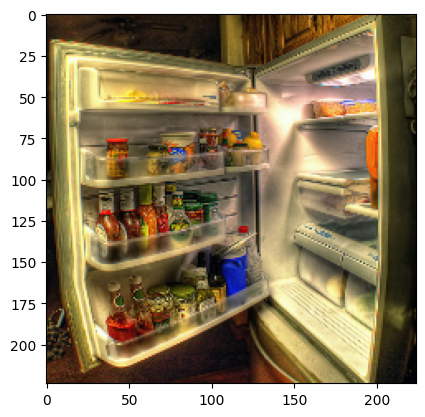

In [ ]:
train_data = dataset_img['train']
sample_0 = train_data[0]
print(f"First sample keys: {sample_0.keys()}")

image_0 = train_data[0]["image"]
plt.imshow(image_0)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class EEGImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = list(hf_dataset)  # Convert iterable to list for indexing
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        eeg = torch.tensor(sample['EEG'], dtype=torch.float32)
        image = sample['image']
        if self.transform:
            image = self.transform(image)
        return eeg, image

 # CLIP MODEL

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import StableDiffusionPipeline
from transformers import CLIPVisionModelWithProjection, CLIPProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

# IP-Adapter uses CLIP ViT-H/14 which has 1024 dimensions
clip_model = CLIPVisionModelWithProjection.from_pretrained(
    "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",  # This produces 1024-dim embeddings
    torch_dtype=dtype
).to(device)

clip_processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# StableDiffusion + IP-Adapter

In [ ]:
# Load Stable Diffusion with IP-Adapter
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype
).to(device)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name="ip-adapter_sd15.bin"
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ip-adapter_sd15.bin:   0%|          | 0.00/44.6M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

# PIPELINE: CLIP + SD + IP-Adapter

In [ ]:
def get_clip_image_embeddings(image):
    if isinstance(image, Image.Image):
        image = [image]

    inputs = clip_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        inputs = {k: v.to(clip_model.dtype) for k, v in inputs.items()}
        outputs = clip_model(**inputs)
        embeddings = outputs.image_embeds
        embeddings = F.normalize(embeddings, p=2, dim=-1)
    return embeddings

  0%|          | 0/30 [00:00<?, ?it/s]

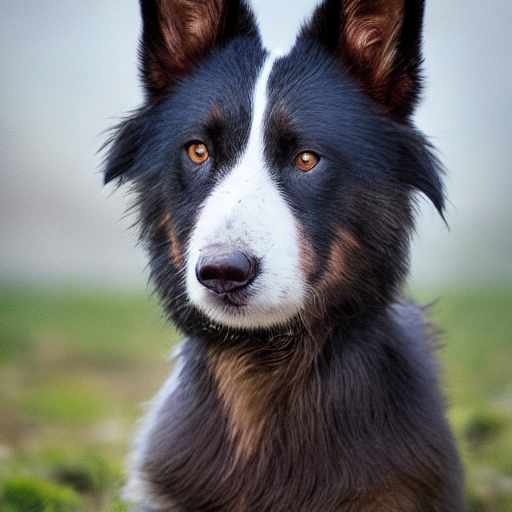

In [ ]:
pipe.set_ip_adapter_scale(0.5) #adapter strength (0-1, default=0.5): Higher values make the output more similar to the reference image

# prepare embeddings for IP-Adapter
input_image = Image.open("/content/dog_picture.jpeg")
#input_image = image_0 #first sample of dataset

positive_embedding = get_clip_image_embeddings(input_image)  # Shape: [1, 1024] Positive_embedding
negative_embedding = torch.zeros_like(positive_embedding)  # Shape: [1, 1024]  Negative_embedding

# Combine embeddings (negative first, then positive)
image_embedding = torch.cat([negative_embedding, positive_embedding], dim=0)  # Shape: [2, 1024]

# sequence dimension that IP-Adapter expects
image_embedding = image_embedding.unsqueeze(1)  # Shape: [2, 1, 1024]

# Generate image
# - num_inference_steps (int, default: 50) denoising steps during image generation
# - guidance_scale (float, default: 7.5 | range:[1-10])) how much the generation is guided by the input image embedding ->  Higher values make the output more similar to the input image, while lower values allow for more variation.
# - num_images_per_prompt (int, default: 1) Specifies how many images to generate for each input.
# - eta (float, default: 0.0) Affects the stochasticity of the denoising process. Higher values introduce more randomness,
# - height and width
# - generator Allows you to set a random seed for reproducibility. needs of generator = torch.Generator(device=device).manual_seed(42)
# - output_type="pil" or "numpy"

output = pipe(
    prompt="",
    ip_adapter_image_embeds=[image_embedding],
    num_inference_steps=30,
    guidance_scale=6.0
).images[0]

display(output)

### Model Pipeline (WIP)

In [ ]:
#tokenized_eeg = TBD
#dataset_img = dataset_img["train"]
columns = dataset_emb["train"].column_names
print(columns)
columns_to_remove = list(set(columns) - set(["EEG","clip_image_embedding"]))
print(columns_to_remove)
dataset = dataset_emb["train"].remove_columns(columns_to_remove)
del dataset_emb
print(dataset.column_names)

['EEG', 'clip_image_embedding', 'subject_id', 'session', 'block', 'trial', '73k_id', 'coco_id', 'curr_time']
['session', 'curr_time', 'subject_id', 'block', '73k_id', 'coco_id', 'trial']
['EEG', 'clip_image_embedding']


In [ ]:
print(dataset.shape)

(42059, 2)


In [ ]:
dataset = dataset.with_format("torch")

In [ ]:
print(dataset)

{'EEG': tensor([[-1.5737e-07, -3.9757e-07,  3.2132e-07,  ..., -1.5839e-06,
         -9.4804e-07, -8.6426e-07],
        [ 5.9007e-07,  1.5436e-07,  9.8109e-07,  ..., -4.8373e-08,
         -1.2862e-06, -2.5605e-06],
        [ 4.2292e-07,  1.2000e-06,  1.5549e-06,  ...,  1.0367e-07,
         -6.6731e-07, -1.2147e-06],
        ...,
        [ 6.9381e-06,  4.7884e-06, -3.5725e-06,  ..., -6.2130e-08,
          1.1360e-09,  8.1945e-07],
        [ 1.9021e-06,  4.9759e-07, -2.6055e-06,  ...,  1.5919e-06,
          1.2992e-06,  1.3225e-06],
        [-1.5479e-07,  8.2434e-08, -8.7258e-07,  ...,  1.2533e-06,
          1.5848e-06,  1.8406e-06]]), 'clip_image_embedding': tensor([-0.0104,  0.0215, -0.0201,  ..., -0.0171, -0.0004,  0.0465])}


In [ ]:
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
tensor_dataset = DataLoader(dataset, batch_size=64)

In [ ]:
print(type("a"))

<class 'str'>


In [ ]:
t1 = None
t2 = None
flag = True
for sample in dataset:
  eeg = sample["EEG"]
  clip = sample["clip_image_embedding"]
  eeg = torch.reshape(eeg, (1,eeg.shape[0],eeg.shape[1]))
  clip = torch.reshape(clip, (1,clip.shape[0]))
  if flag:
    t1 = eeg
    t2 = clip
    flag = False

  else:
    t1 = torch.cat((t1, eeg), 0)
    t2 = torch.cat((t2, clip), 0)

print(t1.shape)
print(t2.shape)

torch.Size([42059, 63, 334])
torch.Size([42059, 1024])


In [ ]:
torch.save(t1, "/mnt/c/Users/loryx/Documenti/sincronizzato_con_drive/data/EEG/EEG.pt")
torch.save(t2, "/mnt/c/Users/loryx/Documenti/sincronizzato_con_drive/data/EEG/CLIP.pt")

In [ ]:
eeg_tensor = torch.load("/mnt/c/Users/loryx/Documenti/sincronizzato_con_drive/data/EEG/EEG.pt")
clip_tensor = torch.load("/mnt/c/Users/loryx/Documenti/sincronizzato_con_drive/data/EEG/CLIP.pt")

In [ ]:
print(eeg_tensor.shape)
print(clip_tensor.shape)

torch.Size([42059, 63, 334])
torch.Size([42059, 1024])


In [ ]:
# remember train test split...

dataset = TensorDataset(eeg_tensor, clip_tensor)
dataloader = DataLoader(dataset, batch_size=4)

In [ ]:
# Input is tensor (batch_size x n_channels[63] x time_dim?[334?])

# One block at a time

# simple MLP do help with transformers
class MLP(nn.Module):

  def __init__(self, in_features, hidden_features=None, out_features=None, activation_fn=nn.GELU, drop=0., dtype=torch.float32):
    super().__init__()
    out_features = out_features or in_features
    hidden_features = hidden_features or in_features
    self.FC_1 = nn.Linear(in_features, hidden_features, dtype=dtype)
    self.activation = activation_fn()
    self.FC_2 = nn.Linear(hidden_features, out_features, dtype=dtype)
    self.dropout = nn.Dropout(drop)

  def forward(self, x):
    x = self.FC_1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.FC_2(x)
    x = self.dropout(x)
    return x

# 1DCNN for tokenization and embedding
class OneDimCNN(nn.Module):

  def __init__(self, input_channels, kernel_size=(11), depth_filters=120, dtype=torch.float32): # kernel size = 1x10 as in the paper
    super().__init__()

    self.depth_filters = depth_filters

    self.CV_1 = nn.Conv1d(in_channels=input_channels, out_channels=input_channels, kernel_size=kernel_size, padding='valid', stride=1, groups=input_channels, dtype=dtype)
    self.CV_2 = nn.Conv1d(in_channels=self.CV_1.out_channels, out_channels=self.CV_1.out_channels, kernel_size=kernel_size, padding='valid', stride=1, groups=self.CV_1.out_channels, dtype=dtype)
    self.CV_3 = nn.Conv1d(in_channels=self.CV_2.out_channels, out_channels=self.depth_filters * self.CV_2.out_channels, kernel_size=kernel_size, padding='valid', stride=1, groups=self.CV_2.out_channels, dtype=dtype)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.CV_1(x)
    x = self.activation(x)
    x = self.CV_2(x)
    x = self.activation(x)
    x = self.CV_3(x)
    x = self.activation(x)
    x = torch.reshape(x, (x.shape[0], (int)(x.shape[1] / self.depth_filters), self.depth_filters, (int)(x.shape[2]))) # B x S x C x D (B x 63 x 120 x 304)

    return x

# Generic Transformer block
class TransformerBlock(nn.Module):

  def __init__(self, emb_size, num_heads, dtype=torch.float32):
    super().__init__()

    self.LN_D = nn.LayerNorm(emb_size, dtype=dtype)
    self.LN_z = nn.LayerNorm(emb_size, dtype=dtype)
    self.MLP = MLP(in_features=emb_size, hidden_features=int(emb_size * 4), dtype=dtype) # 4 * hidden features

    self.MHA = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, batch_first=True)

  def forward(self, x): # no cross attention in this model...
    residual = x # residual cnnection
    x = self.LN_D(x)
    x, _ = self.MHA(x,x,x)
    x+=residual
    residual = x # residual cnnection
    x = self.LN_z(x)
    x = self.MLP(x) + residual
    return x

# comment
class RegionalTransformerModule(nn.Module):

  def __init__(self, input_shape, num_heads, num_blocks, dtype=torch.float32): # Need input to figure out shapes...
    super().__init__()
    # input B x S x C x D
    self.dtype=dtype
    self.batch_size = input_shape[0] # save B
    self.time_size = input_shape[1] # save S
    self.emb_size = input_shape[3] # take D

    if self.emb_size % num_heads != 0 or int(self.emb_size / num_heads) == 0:
      print(f"ERROR 1 - RTM : self.Dh = {int(self.emb_size / num_heads)} != {self.emb_size}/{num_heads} \nTry with different num_heads")

    # Adding a new linearity as seen in the paper
    self.M = nn.Parameter(torch.randn(self.emb_size, input_shape[3], dtype=self.dtype)*1e-2)  # D x D # This could probably be a nn.Linear?
    self.e = nn.Parameter(torch.randn(self.time_size, input_shape[2]+1, self.emb_size, dtype=self.dtype)*1e-2)  # S x C x D
    self.cls = nn.Parameter(torch.zeros(input_shape[0], self.time_size, 1, self.emb_size, dtype=self.dtype))

    # Tranformers blocks
    self.TFB = nn.ModuleList([TransformerBlock(emb_size=self.emb_size, num_heads=num_heads, dtype=dtype) for _ in range(num_blocks)])

  def forward(self, x):
    x = x.transpose(1, 2).transpose(2, 3)  # B x C x D x S

    x = torch.einsum('lm,bjmi -> bijl', self.M, x) # z -> B x S x C x D
    x = torch.cat((self.cls, x), dim=2)
    x = torch.add(x, self.e)  # z -> B x S x C x D

    x = torch.reshape(x, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3])) # BS x C x D

    for tfb in self.TFB:
      x = tfb(x)

    x = torch.reshape(x, (self.batch_size, self.time_size, x.shape[1], x.shape[2])) # B x S x C x D

    return x  # B x S x C x D - z4 in the paper

# comment
class SynchronousTransformerModule(nn.Module):

  def __init__(self, input_shape, num_heads, num_blocks, dtype=torch.float32): # Need input to figure out shapes...
    super().__init__()
    # input B x S x C x D
    self.dtype=dtype
    self.batch_size = input_shape[0] # save B
    self.channel_size = input_shape[2] # save C
    self.emb_size = input_shape[3] # take D

    if self.emb_size % num_heads != 0 or int(self.emb_size / num_heads) == 0:
      print(f"ERROR 1 - RTM : self.Dh = {int(self.emb_size / num_heads)} != {self.emb_size}/{num_heads} \nTry with different num_heads")

    # Adding a new linearity as seen in the paper # Smaller to reduce computational strain as stated in the paper
    self.M = nn.Parameter(torch.randn(self.emb_size, input_shape[3], dtype=self.dtype)*1e-2)  # D x D # This could probably be a nn.Linear?
    self.e = nn.Parameter(torch.randn(self.channel_size, input_shape[1]+1, self.emb_size, dtype=self.dtype)*1e-2)  # C x S x D
    self.cls = nn.Parameter(torch.zeros(input_shape[0], self.channel_size, 1, self.emb_size, dtype=self.dtype))

    # Tranformers blocks
    self.TFB = nn.ModuleList([TransformerBlock(emb_size=self.emb_size, num_heads=num_heads, dtype=dtype) for _ in range(num_blocks)])

  def forward(self, x):
    x = x.transpose(2, 3)  # B x S x D x C
    x = torch.einsum('lm,bjmi -> bijl', self.M, x) # z -> B x C x S x D
    x = torch.cat((self.cls, x), dim=2)
    x = torch.add(x, self.e)  # z -> B x C x S x D


    x = torch.reshape(x, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3])) # BC x S x D

    for tfb in self.TFB:
      x = tfb(x)

    x = x = torch.reshape(x, (self.batch_size, self.channel_size, x.shape[1], x.shape[2])) # B x C x S x D

    return x  # B x C x S x D - z5 in the paper

# comment
class TemporalTransformerModule(nn.Module):

  def __init__(self, input_shape, red_size, num_heads, num_blocks, dtype=torch.float32):
    super().__init__()
    # input # B x C x S x D # alredy in (almost) good shape
    self.dtype=dtype
    self.input_emb_size = input_shape[3] # take D
    self.channel_size = input_shape[1] #save C
    self.time_size = input_shape[2] # save S

    self.new_size = red_size

    if self.input_emb_size % self.new_size != 0:
      print(f"Error, don't make this harder than it has to be")

    self.emb_size = input_shape[1]*input_shape[2] # L1

    if self.emb_size % num_heads != 0 or int(self.emb_size / num_heads) == 0:
      print(f"ERROR 1 - RTM : self.Dh = {int(self.emb_size / num_heads)} != {self.emb_size}/{num_heads} \nTry with different num_heads")


    # Adding a new linearity as seen in the paper
    self.M = nn.Parameter(torch.randn(self.emb_size, self.emb_size, dtype=self.dtype)*1e-2)  # L1 x L1 # This could probably be a nn.Linear?
    self.e = nn.Parameter(torch.randn(self.new_size+1, self.emb_size, dtype=self.dtype)*1e-2)  # L1 x M
    self.cls = self.cls = nn.Parameter(torch.zeros(input_shape[0], 1, self.emb_size, dtype=self.dtype))

    # Tranformers blocks
    self.TFB = nn.ModuleList([TransformerBlock(emb_size=self.emb_size, num_heads=num_heads, dtype=dtype) for _ in range(num_blocks)])

  def forward(self, x):
    x = torch.reshape(x,(x.shape[0], x.shape[1]*x.shape[2], self.new_size, self.input_emb_size//self.new_size))
    x = torch.mean(x,dim=3, keepdim=False) # Yes, einsum would have been quicker
    # B x (C x S) x M -> B x L x M
    x = x.transpose(1,2) # B x M x L

    x = torch.einsum('lm,bim -> bil', self.M, x) # z -> B x M x L
    x = torch.cat((self.cls, x), dim=1)
    x = torch.add(x, self.e)  # z -> B x M x L

    for tfb in self.TFB:
      x = tfb(x)

    x = torch.reshape(x, (x.shape[0], self.new_size+1, self.time_size, self.channel_size)) # it's the last layer, might as well flatten...

    return x

# Fusing all layers toghether into an encoder
class EEGEncoder(nn.Module):

  def __init__(self, input_shape, hidden_dim, kernel_size=11, num_heads=2, num_blocks=1, dtype=torch.float32): # input 63 x 334
    super().__init__()
    self.dtype=dtype
    self.in_channels = input_shape[1]
    self.time_dim = input_shape[2]
    self.batch_size = input_shape[0]

    # compute in and out dim
    self.outshape1 = (self.batch_size, self.in_channels, 120, input_shape[2] - 3 * (kernel_size - 1))
    self.outshape2 = (self.batch_size, self.outshape1[1], self.outshape1[2]+1, self.outshape1[3])
    self.outshape3 = (self.batch_size, self.outshape2[2], self.outshape2[1]+1, self.outshape2[3])
    self.outshape4 = (self.batch_size, (hidden_dim+1), self.outshape3[2], self.outshape3[1])

    print("aaaa")
    print(self.outshape1)
    print(self.outshape2)
    print(self.outshape3)
    print(self.outshape4)
    print("aaa")

    # NN layers
    self.CNN = OneDimCNN(self.in_channels, kernel_size=kernel_size)
    self.RTM = RegionalTransformerModule(self.outshape1, num_heads, num_blocks)
    self.STM = SynchronousTransformerModule(self.outshape2, num_heads, num_blocks)
    self.TTM = TemporalTransformerModule(self.outshape3, red_size=hidden_dim, num_heads=num_heads, num_blocks=num_blocks)
    self.final = MLP(in_features=self.outshape4[1]*self.outshape4[2]*self.outshape4[3]self.outshape4[4], hidden_features=2048, out_features=1024)

  def forward(self, x):
    print(x.shape)
    x = self.CNN(x)
    print(x.shape)
    x = self.RTM(x)
    print(x.shape)
    x = self.STM(x)
    print(x.shape)
    x = self.TTM(x)
    print(x.shape)
    x = torch.reshape(x,(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
    return self.final(x)


In [ ]:
# Loss function(s)

class ContrastiveLoss(nn.Module):
    """
    InfoNCE
    """
    def _init_(self, temperature=0.07):
        super()._init_()
        self.temperature = temperature

    def forward(self, eeg_embeddings, clip_embeddings):
        """
        Args:
            eeg_embeddings: (batch_size, 1024)
            clip_embeddings: (batch_size, 1024)
        """
        # norm
        eeg_embeddings = F.normalize(eeg_embeddings, p=2, dim=1)
        clip_embeddings = F.normalize(clip_embeddings, p=2, dim=1)

        # Compute cosine similarity matrix: (batch_size, batch_size)
        similarity_matrix = torch.matmul(eeg_embeddings, clip_embeddings.T) / self.temperature

        # positive pairs are on the diagonal
        batch_size = eeg_embeddings.shape[0]
        labels = torch.arange(batch_size, device=eeg_embeddings.device)

        # Compute bidirectional cross-entropy loss
        loss_eeg_to_clip = F.cross_entropy(similarity_matrix, labels)
        loss_clip_to_eeg = F.cross_entropy(similarity_matrix.T, labels)

        # Return symmetric loss
        return (loss_eeg_to_clip + loss_clip_to_eeg) / 2

class MSELoss(nn.Module):
    """
    Simple Mean Squared Error loss for regression-based alignment
    Alternative to contrastive loss
    """
    def _init_(self):
        super()._init_()
        self.mse = nn.MSELoss()

    def forward(self, eeg_embeddings, clip_embeddings):
        # Normalize embeddings before computing MSE
        eeg_embeddings = F.normalize(eeg_embeddings, p=2, dim=1)
        clip_embeddings = F.normalize(clip_embeddings, p=2, dim=1)
        return self.mse(eeg_embeddings, clip_embeddings)

In [ ]:
# Lightning module for training
class LightingWrapper(pylight.LightningModule):

    def __init__(
        self,
        model: torch.nn.Module,
        personalized_loss : callable,
        ):

        super().__init__()
        self.model = model
        self.loss = personalized_loss
        self.acc = nn.CosineSimilarity()

    def forward(self, x):
        return self.model(x,y)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters())

    def step(self, batch, name='train', on_step=True, on_epoch=False):
        xb, yb = batch
        xb = self(xb)
        loss = self.loss(xb, yb)
        acc = self.acc(xb, yb)

        # choose log dir
        self.log(f"{name}/loss", loss.type(torch.float32), on_step=on_step, on_epoch=on_epoch, prog_bar=True)
        self.log(f"{name}/acc", acc.type(torch.float32), on_step=on_step, on_epoch=on_epoch, prog_bar=True)
        return loss

    def training_step(self, batch, _):
        return self.step(batch, "train", on_step=True, on_epoch=False)

    def validation_step(self, batch, _):
        return self.step(batch, "val", on_step=False, on_epoch=True)

    def test_step(self, batch, _):
        return self.step(batch, "test", on_step=True, on_epoch=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
test_batch=None
for i, j in dataloader:
  print(i.shape)
  print(j.shape)
  test_batch=i.to(device)
  break

torch.Size([4, 63, 334])
torch.Size([4, 1024])


In [ ]:
# TESTING DIMENSIONS
model = EEGEncoder(test_batch.shape, 38).to(device)


aaaa
(4, 63, 120, 304)
(4, 63, 121, 304)
(4, 121, 64, 304)
(4, 39, 64, 121)
aaa


In [ ]:
x = model(test_batch)

torch.Size([4, 63, 334])
torch.Size([4, 63, 120, 304])
torch.Size([4, 63, 121, 304])
torch.Size([4, 121, 64, 304])
torch.Size([4, 39, 64, 121])


In [ ]:
print(x)

tensor([[[[-1.4822e-01,  1.0116e-01, -4.9790e-02,  ..., -3.1899e-01,
           -6.1795e-02,  5.9115e-01],
          [-1.0705e-01,  4.9396e-01,  7.6560e-02,  ..., -1.3487e-01,
            4.1056e-01,  1.8503e-01],
          [-6.2699e-02, -1.4142e-01, -2.2736e-01,  ..., -2.8812e-01,
            1.1768e-01,  1.7999e-01],
          ...,
          [ 1.6082e-01,  3.9570e-03,  7.3379e-02,  ...,  4.4673e-01,
            3.1809e-01, -8.4259e-02],
          [-1.3120e-01, -3.5283e-01, -1.3406e-01,  ...,  5.7680e-02,
            2.5624e-01,  1.8325e-01],
          [ 1.2347e-01,  9.2511e-03, -2.2194e-01,  ...,  1.1699e-01,
            3.5674e-01, -2.1702e-01]],

         [[ 1.8981e+02,  1.3892e+03,  2.6362e+03,  ...,  2.1403e+03,
           -1.2560e+03,  1.3655e+03],
          [-4.1094e+03,  1.7637e+02,  1.0317e+03,  ..., -5.9870e+02,
            2.0241e+03, -1.8247e+03],
          [-1.1613e+03, -1.2978e+02,  1.0001e+03,  ...,  2.0805e+03,
            1.4724e+03, -3.4222e+03],
          ...,
     

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()